In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Summary

Resnet50-based model with sigmoid outputs.

No learning rate scheduler.

Converges in ~10 epochs on PascalVOC training set.

#### Hyperparameters
- Learning Rate: `1e-4`
- Optimizer: `Adam`
- Batch size: `8`
- Loss function: *Classwise Binary Cross-Entropy*

#### Metrics
- Accuracy: `0.9628`
- Mean AP: `0.7286`
- Mean Tail Accuracy: `0.9116`

## Dependencies

Install this project's dependencies via `pip install -r requirements.txt`

I use [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/introduction_guide.html) to facilitate experiment logging. This library does not abstract any significant functionality of Pytorch other than the training loop (which is mostly copy-pasted code anyway).

In [54]:
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import average_precision_score
from PIL import Image
import matplotlib.pyplot as plt
import shutil

import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from voc_data import VOCDataset, PascalVOC

%matplotlib inline

## Multilabel Classifier

The classifier is based on Resnet50 (pre-trained on ImageNet).

The final fully-connected layer is replaced with a new randomly initialized layer that has 20 outputs rather than the default 1000, and the sigmoid function is applied to its outputs.

## Model Training

The loss function I use is based on Pytorch's [`binary_cross_entropy`](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy). This function is applied class-wise and averaged to obtain the loss value (see `VOCClassifier._multi_label_loss` for implementation).

The label for each sample is represented as a many-hot vector, with negative classes being `0` and positive ones being `1`.

During both training and inference, images are resized (shortest edge = 400px), FiveCropped and stacked, then normalized.

During training, I apply additional augmentation (random horizontal flipping and rotation).

In [4]:
class VOCClassifier(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, log_every_n_steps=10):
        super().__init__()
        self.log_every_n_steps = log_every_n_steps
        # Hyperparameters
        self.learning_rate = learning_rate

        # Model definition
        self.stem = torchvision.models.resnet50(pretrained=True, progress=True)
        self.stem.fc = torch.nn.Linear(2048, 20)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        if len(x.shape) == 5:
            bs, ncrops, c, h, w = x.size()
            x = self.stem(x.view(-1, c, h, w))
            x = x.view(bs, ncrops, -1).max(1)[0]
        elif len(x.shape) == 4:
            x = self.stem(x)
        else:
            raise ValueError(f"Expected input to have rank 4 or 5, got {x.shape} (rank {len(x.shape)}) instead")
        x = self.sigmoid(x)
        return x

    @staticmethod
    def _multi_label_loss(pred, labels):
        loss = 0
        for i in range(labels.shape[1]):
            loss += F.binary_cross_entropy(pred[:, i].double(), labels[:, i].double())
        return loss / labels.shape[1]

    def training_step(self, batch, batch_idx):
        image, labels, _ = batch
        pred = self.forward(image)
#         loss = F.binary_cross_entropy(pred, labels)
        loss = self._multi_label_loss(pred, labels)
        output = {"loss": loss}
        if self.log_every_n_steps and batch_idx % self.log_every_n_steps == 0:
            tensorboard_logs = {"train_loss": loss}
            output["log"] = tensorboard_logs
        return output

    def validation_step(self, batch, batch_idx):
        image, labels, _ = batch
        pred = self.forward(image)
#         loss = F.binary_cross_entropy(pred, labels)
        loss = self._multi_label_loss(pred, labels)
        correct = ((pred > 0.5) == labels).sum().float()
        count = labels.shape[0] * labels.shape[1]
        output = {
            "val_loss": loss,
            "correct": correct, "count": count,
            "pred": pred, "labels": labels
        }
        return output

    def validation_end(self, outputs):
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        correct = torch.stack([x["correct"] for x in outputs]).sum()
        accuracy = correct / sum([x["count"] for x in outputs])
        all_labels = torch.cat([x["labels"] for x in outputs]).cpu().detach().numpy()
        all_pred = torch.cat([x["pred"] for x in outputs]).cpu().detach().numpy()
        mean_ap = average_precision_score(all_labels, all_pred, None).mean()

        tensorboard_logs = {"val_loss": avg_val_loss, "val_acc": accuracy}
        if np.isfinite(mean_ap):
            tensorboard_logs["mean_ap"] = mean_ap
        return {"val_loss": avg_val_loss, "log": tensorboard_logs}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [64]:
ROOT_DIR = "./data/VOCdevkit/VOC2012/"
MODEL_PATH = Path("models/model_fivecrop_flip.pt")
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
SHUFFLE = True

In [6]:
# VOC data helper
voc = PascalVOC(ROOT_DIR)

# Data transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()
base_transform = transforms.Compose([
    transforms.Resize(400),
    transforms.FiveCrop(224),
    transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops])),
])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(contrast=0.25, saturation=0.25),
    base_transform,
])

# Datasets and DataLoaders
train_dataset = VOCDataset(voc, split="train", transform=train_transform)
val_dataset = VOCDataset(voc, split="val", transform=base_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=2)

In [7]:
model = VOCClassifier(learning_rate=LEARNING_RATE)
print(model)

VOCClassifier(
  (stem): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

`pytorch_lightning` comes in here.

It handles the training loop and the moving of tensors to GPU(s), as well as logging of metrics for visualization in Tensorboard.

In [ ]:
pl_logger = pl.loggers.TestTubeLogger(save_dir="experiments/")
trainer = pl.Trainer(
    gpus=[0],
    logger=pl_logger,
    progress_bar_refresh_rate=10,
#     val_check_interval=0.1,
#     val_percent_check=0.25,
    overfit_pct=0.25,
)

In [ ]:
trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

## Save Model

In [66]:
if MODEL_PATH.exists():
    raise ValueError("Model with that name already exists. Refusing to overwrite.")
torch.save(model.state_dict(), MODEL_PATH)

ValueError: Model with that name already exists. Refusing to overwrite.

## Load Model

In [9]:
sd = torch.load(MODEL_PATH)
model.load_state_dict(sd)

<All keys matched successfully>

## Model Evaluation

In [10]:
def get_predictions(model, dataloader, cuda=True, subset=None):
    all_labels = []
    all_pred = []
    all_paths = []

    if subset:
        assert isinstance(subset, float) and 0 < subset < 1
    max_samples = int(np.ceil(len(dataloader) * subset)) if subset else len(dataloader)

    # Get predictions
    with torch.no_grad():
        for i, (image, labels, path) in tqdm(enumerate(dataloader), total=max_samples, ncols='100%'):
            if cuda:
                model.cuda()
                image = image.cuda()
                labels = labels.cuda()
            pred = model(image)
            all_labels.append(labels.cpu().numpy())
            all_pred.append(pred.cpu().numpy())
            all_paths.append(path)

            if subset and i >= max_samples:
                break

    labels = np.concatenate(all_labels, 0)
    pred = np.concatenate(all_pred, 0)
    paths = np.concatenate(all_paths)

    return pred, labels, paths

pred, labels, paths = get_predictions(model, val_dataloader, cuda=True, subset=None)

Accuracy: 0.9628284389489954
Average Precision: [0.90154388 0.75927758 0.81515773 0.72510909 0.5123822  0.85176327
 0.80504543 0.89883597 0.57333306 0.61246603 0.53352054 0.83452248
 0.70566054 0.78140663 0.94029254 0.56839073 0.75188008 0.45492436
 0.80734184 0.74007774]
Mean Average Precision: 0.7286465859370039


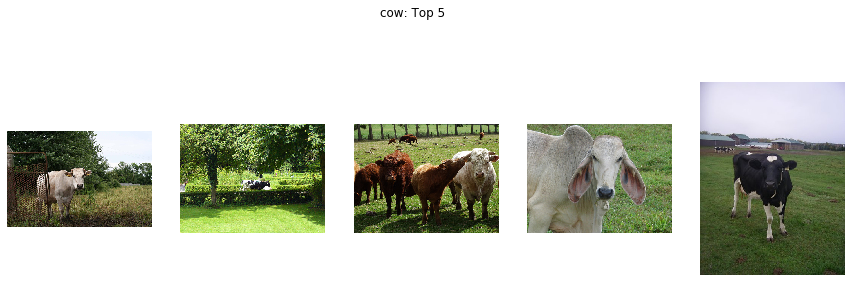

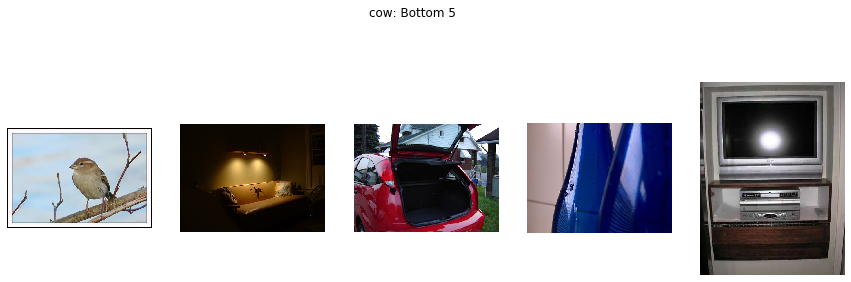

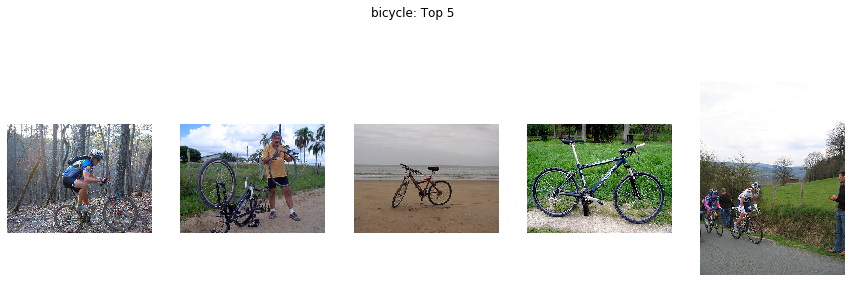

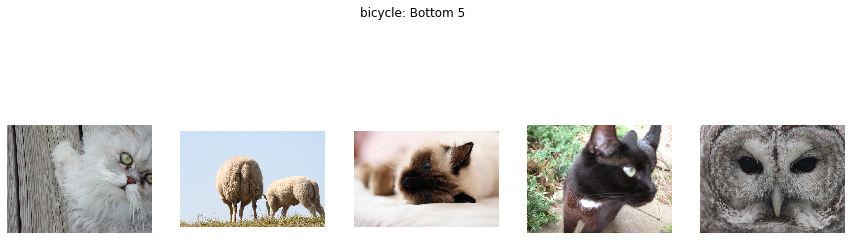

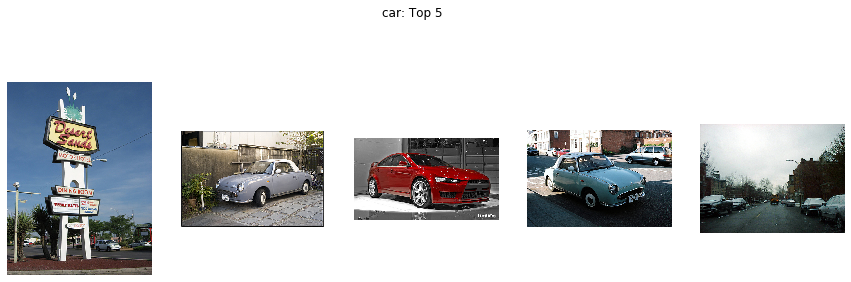

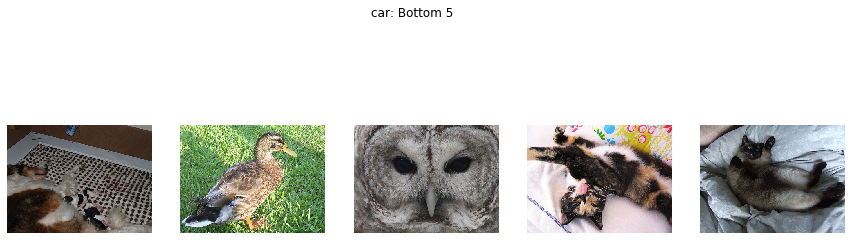

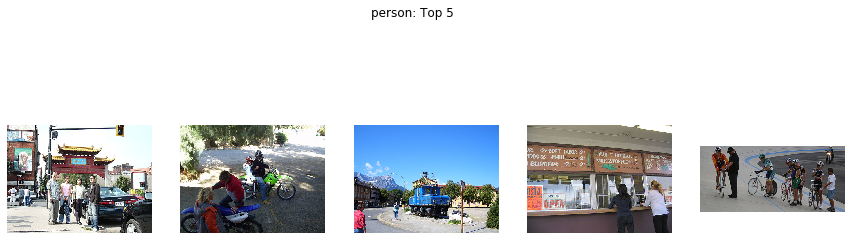

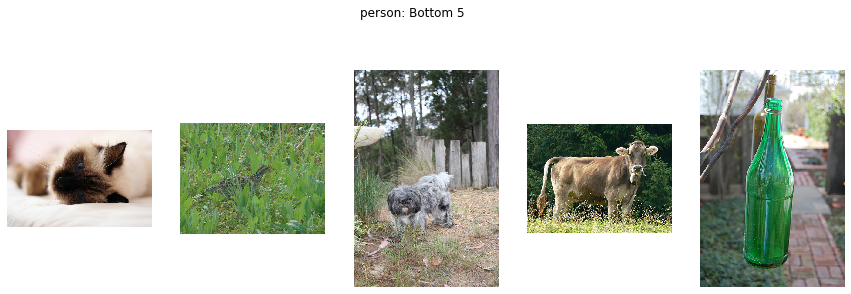

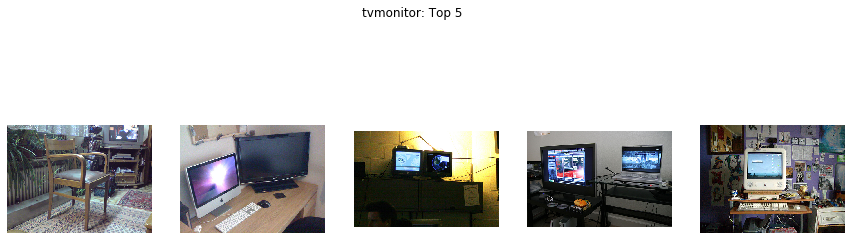

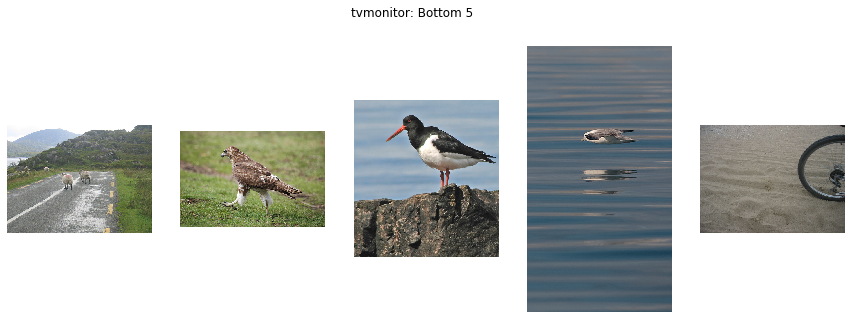

Tail accuracies [0.95522384 0.93589732 0.98275856 0.83647793 0.9342104  0.9999998
 0.97435893 0.9478908  0.75555551 0.73493967 0.72093006 0.96193768
 0.92941166 0.97727251 0.98116297 0.8765431  0.93589732 0.81481451
 0.990909   0.98684198]
Mean tail accuracy 0.9116516779852489


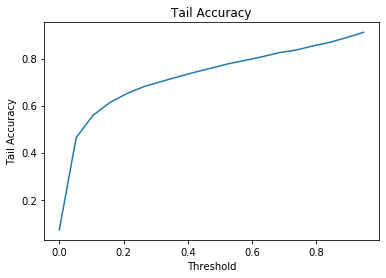

In [71]:
def show_images(image_paths, title, size=200):
    num_images = len(image_paths)
    images = [Image.open(path) for path in image_paths]
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i, ax in enumerate(axs.reshape(-1)):
        ax.axis("off")
        ax.imshow(Image.open(image_paths[i]))
    fig.suptitle(title)
    plt.show()

def visualize_top_and_bottom_k(
    pred, paths, cat_names,
    k=50, num_classes=5, total_classes=20,
    output_dir="data/output",
):
    # Top and bottom K image visualization (on randomly chosen classes)
    output_path = Path(output_dir)
    class_indices = np.random.choice(list(range(total_classes)), size=num_classes, replace=False)
    for class_index in class_indices:
        class_name = cat_names[class_index]
        sorted_indices = np.argsort(pred[:, class_index])
        # Top K
        top = sorted_indices[-k:]
        for i, src in enumerate(paths[top]):
            dst = output_path / f"top/{class_name}/{k - i}.jpg"
            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)
        show_images(paths[top], f"{class_name}: Top {k}")
        # Bottom K
        bottom = sorted_indices[:k]
        for i, src in enumerate(paths[bottom]):
            dst = output_path / f"bottom/{class_name}/{i + 1}.jpg"
            dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src, dst)
        show_images(paths[bottom], f"{class_name}: Bottom {k}")

def show_tail_accuracy(pred, labels, start, num_steps=20):
    end = pred.max(0)[0].min()
    steps = np.linspace(start, end, num=num_steps)[:-1]

    tail_accuracies = []
    for step in steps:
        classwise_tailacc = np.reshape(
            (np.sum((pred > step) * labels, 0) / (np.sum(pred > step, 0) + 1e-5)),
            (1, -1)
        )
        tail_accuracies.append(classwise_tailacc)
    tail_accuracies = np.concatenate(tail_accuracies)
    print("Tail accuracies", tail_accuracies[-1])
    print("Mean tail accuracy", tail_accuracies[-1].mean())
    plt.figure()
    plt.plot(steps, tail_accuracies.mean(1))
    plt.title("Tail Accuracy")
    plt.xlabel("Threshold")
    plt.ylabel("Tail Accuracy")
    plt.savefig("tail_accuracy.png")
    plt.show()

def evaluate_model(pred, labels, paths, voc):
    cat_names = voc.list_image_sets()

    # Binarize predictions
    pred_binary = pred > 0.5

    # Average precision
    ap = average_precision_score(labels, pred, None)
    mean_ap = ap.mean()

    # Accuracy
    correct = np.sum(pred_binary == labels)
    total = labels.shape[0] * labels.shape[1]
    accuracy = correct / total

    print("Accuracy:", accuracy)
    print("Average Precision:", ap)
    print("Mean Average Precision:", mean_ap)
    visualize_top_and_bottom_k(
        pred, paths, cat_names,
        k=5, num_classes=5, total_classes=20,
        output_dir="data/output",
    )
    show_tail_accuracy(pred, labels, 0, num_steps=20)

evaluate_model(pred, labels, paths, voc)

In [ ]:
model.cuda()
for image, labels in train_dataloader:
    pred = model(image.cuda()[:1])
    print("Ground Truth:", labels[:1])
    print("Predictions:", pred)
    break